조금 더 정교하게 리밸런싱

In [1]:
import os
import json
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

from tools.portfolio import simulate_longonly
from tools.stats import print_statistics

In [2]:
price_df = pd.read_pickle("data/asset_cc2.pkl")
six_four = pd.read_pickle("data/6-4.pkl")
seven_three = pd.read_pickle("data/7-3.pkl")
eight_two = pd.read_pickle("data/8-2.pkl")

In [3]:
with open("results/res(k4)/result_weightsfull.json", 'r', encoding='utf-8') as f:
    daily_weight = json.load(f)

daily_weight = pd.DataFrame(daily_weight).T
daily_weight.columns = price_df.columns
daily_weight.index = pd.to_datetime(daily_weight.index)

In [4]:
with open("results/res(k4)/estimated_regimefull.json", 'r', encoding='utf-8') as f:
    regime = json.load(f)

In [5]:
b = [i for i in regime]

In [6]:
change_dict = {}

for inner_dict in regime:
    sorted_dates = sorted(inner_dict.keys())
    
    day1 = inner_dict[sorted_dates[-2]]
    day2 = inner_dict[sorted_dates[-1]]
    
    change = 0 if day1 == day2 else 1
    change_dict[sorted_dates[-2]] = change

In [7]:
change_series = pd.Series(change_dict)
change_series.index = pd.to_datetime(change_series.index)
change_series.sort_index(inplace=True)

In [8]:
change_date = change_series.loc[change_series==1].index

In [9]:
new_reb_dates = []

last_reb_date = daily_weight.index[0]
new_reb_dates.append(last_reb_date)

for date in daily_weight.index[1:]:
    # (A) 원래 리밸런싱 날짜라면
    if date in change_date:
        last_reb_date = date
        new_reb_dates.append(date)
        continue

    # (B) 마지막 리밸런싱 후 30일 이상 지났다면
    if (date - last_reb_date) >= pd.Timedelta(days=30):
        last_reb_date = date
        new_reb_dates.append(date)

# 최종 결과
new_reb_dates = pd.DatetimeIndex(new_reb_dates)
new_reb_dates

DatetimeIndex(['2007-03-02', '2007-04-02', '2007-04-03', '2007-05-03',
               '2007-05-07', '2007-05-18', '2007-06-18', '2007-07-18',
               '2007-07-31', '2007-08-01',
               ...
               '2025-03-27', '2025-03-28', '2025-03-31', '2025-04-01',
               '2025-04-02', '2025-04-03', '2025-04-04', '2025-04-08',
               '2025-04-09', '2025-04-11'],
              dtype='datetime64[ns]', length=869, freq=None)

In [10]:
weight_resampled = daily_weight.loc[new_reb_dates]

<Axes: >

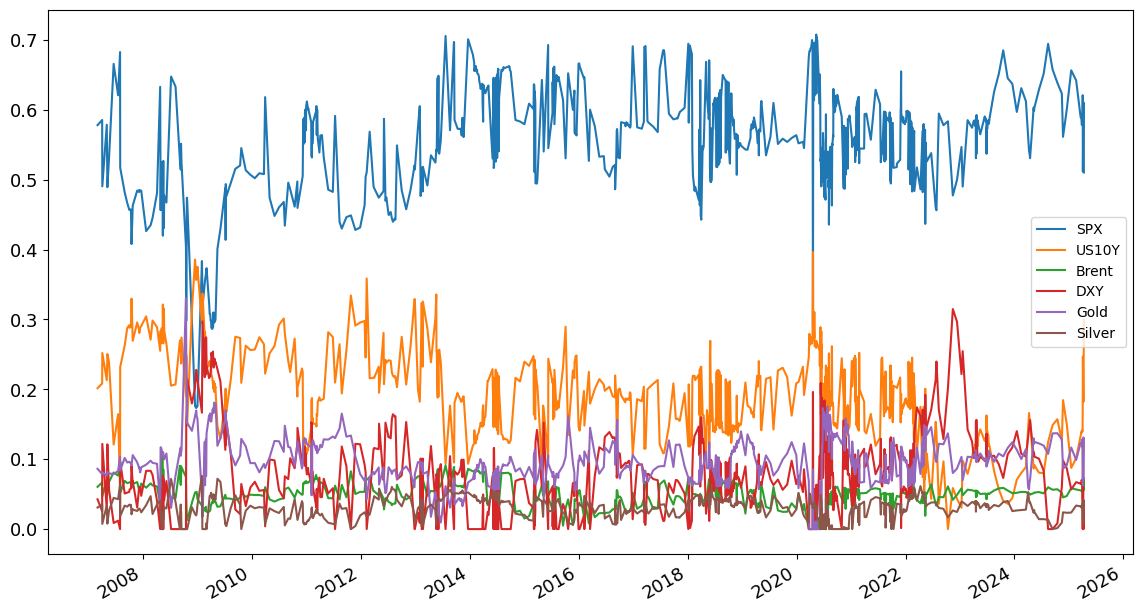

In [11]:
weight_resampled = weight_resampled.rename(
    {
        "snp":"SPX",
        "t10":"US10Y",
        "brent":"Brent",
        "dxy":"DXY",
        "gold":"Gold",
        "silver":"Silver",
    }, axis=1).loc[:, ["SPX","US10Y","Brent", "DXY", "Gold", "Silver"]]

weight_resampled.plot(figsize=(14,8), fontsize=13)

In [12]:
price_df = price_df.rename(
    {
        "snp":"SPX",
        "t10":"US10Y",
        "brent":"Brent",
        "dxy":"DXY",
        "gold":"Gold",
        "silver":"Silver",
    }, axis=1).loc[:, ["SPX","US10Y","Brent", "DXY", "Gold", "Silver"]]

In [13]:
result = simulate_longonly(
    group_weight_df=weight_resampled,
    price_df=price_df,
    fee_rate=0.001,
)

In [14]:
snp = price_df['SPX'].loc[result.index]
snp = snp / snp.iloc[0]

In [19]:
result.pct_change().to_pickle("results/k4.pkl")

In [15]:
cc_dict = {
    "Model":result.pct_change(),
    "6:4":six_four.pct_change(),
    "7:3":seven_three.pct_change(),
    "8:2":eight_two.pct_change(),
    "S&P 500":snp.pct_change(),
}

stats_cc = print_statistics(cc_dict)
print(stats_cc.to_latex(float_format="%.2f"))

\begin{tabular}{lrrrrr}
\toprule
 & Mean & Std & Sharpe & Cum & Mdd \\
\midrule
Model & 9.63 & 13.32 & 0.72 & 197.15 & 31.90 \\
6:4 & 8.76 & 13.56 & 0.65 & 165.31 & 33.99 \\
7:3 & 10.18 & 16.02 & 0.64 & 202.71 & 40.29 \\
8:2 & 11.63 & 18.67 & 0.62 & 242.39 & 46.28 \\
S&P 500 & 14.62 & 24.34 & 0.60 & 326.55 & 56.77 \\
\bottomrule
\end{tabular}



In [16]:
pf_cum = (pd.DataFrame(cc_dict).fillna(0)+1).cumprod()
dd = (pf_cum - pf_cum.cummax()) / pf_cum.cummax()
pf_log = np.log(pf_cum)

(-0.59, 0.0)

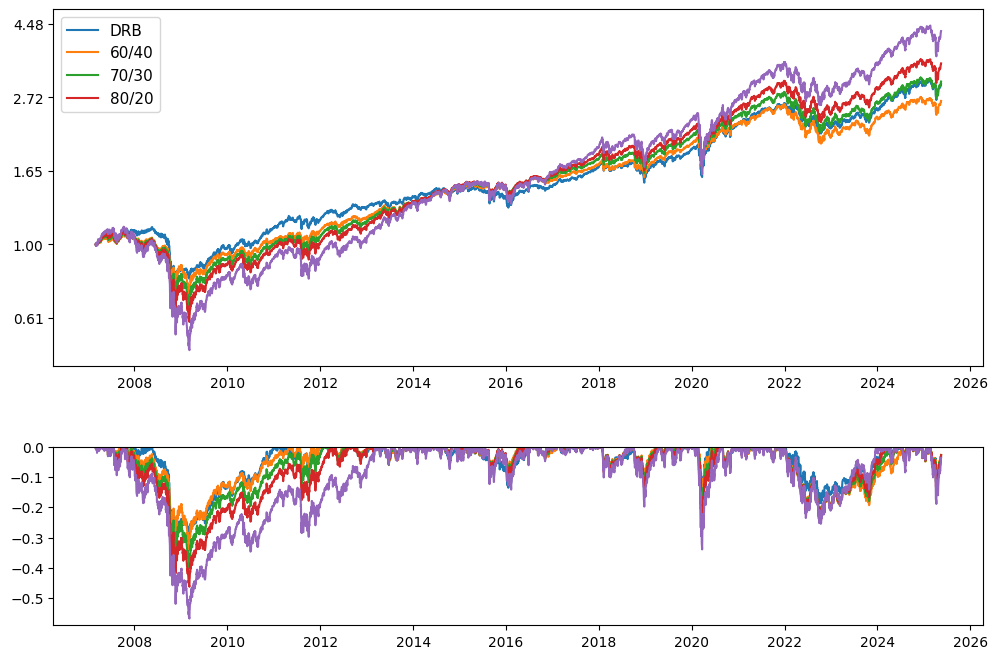

In [17]:
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[2, 1], hspace=0.3)

ax1 = fig.add_subplot(gs[0, 0])
for col in pf_log.columns:
    ax1.plot(pf_log.index, pf_log[col], label=col)
ax1.legend(["DRB", "60/40", "70/30", "80/20"], loc='upper left', fontsize=11)

def y_fmt(log_val, pos):
    return f"{np.exp(log_val):.2f}"
ax1.yaxis.set_major_formatter(FuncFormatter(y_fmt))

ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
for col in dd.columns:
    ax2.plot(dd.index, dd[col], label=col)

ax2.set_ylim(-0.59, 0)

In [18]:
after_2016 = print_statistics(pd.DataFrame(cc_dict)["2016":])
print(after_2016.to_latex(float_format="%.2f"))

\begin{tabular}{lrrrrr}
\toprule
 & Mean & Std & Sharpe & Cum & Mdd \\
\midrule
Model & 12.96 & 13.76 & 0.94 & 116.01 & 19.86 \\
6:4 & 10.14 & 13.12 & 0.77 & 81.16 & 23.55 \\
7:3 & 12.34 & 15.21 & 0.81 & 104.75 & 23.93 \\
8:2 & 14.57 & 17.47 & 0.83 & 130.61 & 26.23 \\
S&P 500 & 19.10 & 22.34 & 0.85 & 189.49 & 33.92 \\
\bottomrule
\end{tabular}



K Plotting

In [20]:
k2 = pd.read_pickle("results/k2.pkl")
k3 = pd.read_pickle("results/k3.pkl")
k4 = pd.read_pickle("results/k4.pkl")
drb = pd.read_pickle("results/drb.pkl")

In [27]:
cc = pd.concat([drb, k2, k3, k4], axis=1)
pf_cum = (cc.fillna(0)+1).cumprod()
dd = (pf_cum - pf_cum.cummax()) / pf_cum.cummax()
pf_log = np.log(pf_cum)

(-0.34, 0.0)

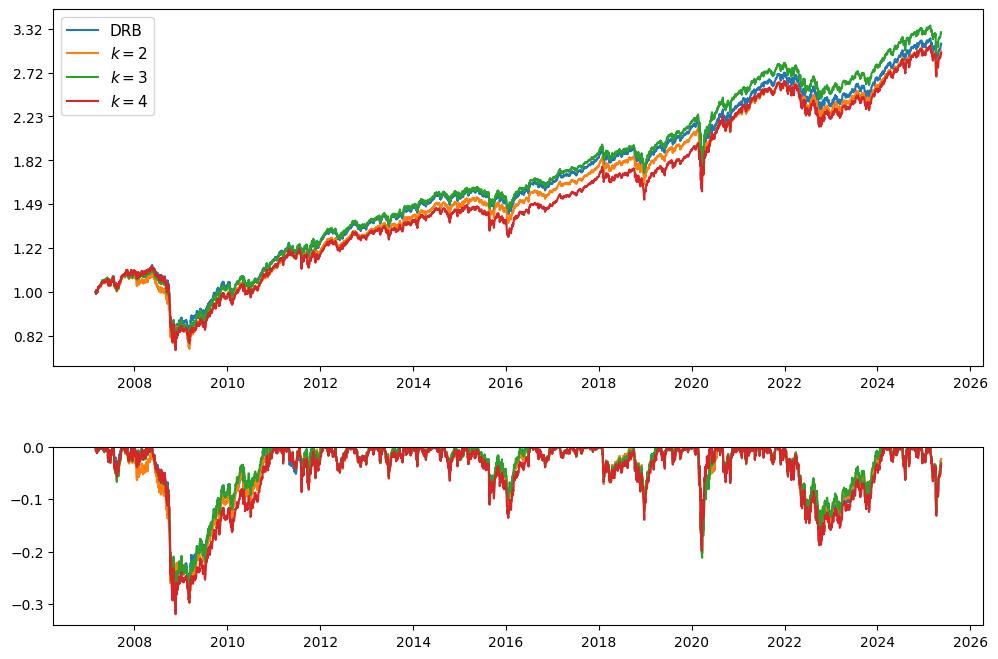

In [31]:
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[2, 1], hspace=0.3)

ax1 = fig.add_subplot(gs[0, 0])
for col in pf_log.columns:
    ax1.plot(pf_log.index, pf_log[col], label=col)
ax1.legend(["DRB", "$k=2$", "$k=3$", "$k=4$"], loc='upper left', fontsize=11)

def y_fmt(log_val, pos):
    return f"{np.exp(log_val):.2f}"
ax1.yaxis.set_major_formatter(FuncFormatter(y_fmt))

ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
for col in dd.columns:
    ax2.plot(dd.index, dd[col], label=col)

ax2.set_ylim(-0.34, 0)